# Project : forecast demand and visualization

## work flow
- import data and library
- EDA : check nulls, outlier, show dtype, statistics analyze
- explore 'Time Series' : min/max dates, check seasonality, trend etc....
- ARIMA model
- conclusion and feedback

- 머신러닝과 시계열분석의 차이점은 '시간축'을 고려하냐 안하냐
- 시계열 분석의 특성 7가지
1. 빈도 : 일단위, 월단위, 연단위로 나누어서 빈도를 측정한다. 비즈니스 사이클이 복잡할 수록 작은 시간축, 간단할수록 월 시간축으로도 가능. 시간축이 안맞아 null값이 발생한다면, bfill, ffill 가능
2. 추세 : 추세는 trend를 말한다. 시계열이 시간에 따라 증가 또는 감소를 말한다. 
3. 계절성 : 계절성은 일정한 빈도로 주기적으로 나타나는 패턴(m), 주기적 패턴이 12개월마다 반복된다면 1년이아니라 m = 12로 설정해야함, sin함수나 cos함수 그려봐서 파악할 것
4. 주기 : 주기는 계절성과 헷갈릴 수 있음, 주기는 일정하지 않은 빈도로 발생하는 패턴을 말함, 쉽게말해서 variance가 비슷하면 계절성이고, 다르면 주기
5. 더미변수 : 더미변수는 이진수의 형태 (0아님1)로 변수를 생성하는 것으로, 휴일, 이벤트, 캠페인 이상치를 생성할 수 있음
    범주형 변수의 기준값은 미리 정해야하며, 각 더미변수의 값을 0또는1로 채우며, 1은 각 더미변수의 정의와 같음을 의미한다.
6. 지연값(lag) : 지연된 값을 독립변수로 반영한다. 과거의 x를 현재에 반영하고 싶을때 사용하며, shift 함수를 사용해서 lag값을 만들 수 있음, shift(1)은 바로 이전의 값, shift(2)는 두 단계 전의 값을 활용
    
- 기본적으로 시계열 데이터 분석은 Numpy와 Pandas를 가지고 분석을 하게 됩니다. statsmodels라는 패키지의(sm)
sm.tsa.seasonal_decompose를 통해 분석을 하게 됩니다. 여기서 parameter를 살펴보면, additive와 multiplicative모델을 고르는 부분이 있습니다. 뭘 선택해야 할지 고민을 할 수 있습니다. 일반적으로 additive모델을 주로 사용합니다. multiplicative모델은 언제 사용하느냐 하면, y가 %, 즉 비율로 표현되어 있을 때 사용하면 됩니다.
sm.tsa.seasonal_decompose를 통해서 개략적으로 파악하고, 잔차까지 확인합니다.


- 시계열 분석 데이터 준비
1. 가장 옛날 것을 훈련(train)데이터로 사용하고, 가장 최근 것을 검증(test)데이터로 사용한다
2. 기간을 두고 훈련 셋을 만든다. 시간축을 잘 보존해야한다.
3. **모델일 월마다 예측력이 다를 수 있기 때문에 월별 모델을 만들기도 한다.

- 검증지표와 잔차진단
검증지표는 예측값과 실제값이 유사한지 측정하는 것이고, 잔차진단은 데이터의 시간패턴을 잘 뽑아내었는지 확인하는 것
검증지표는 MSE가 대표적임 MAE. MAPE, MPE(y가 %로 나올때!!), 다 사용해보고 값이 안정될 떄 까지 시도해보기

- 잔차의 정의
1. 잔차들은 정규분포이니, 평균0과 일정한 분산을 가져야한다
2. 잔차들이 시간의 흐름에 따라 상관성이 없어야한다

- 시간영역 선택방법은 시간축을 년, 월, 일주일, 다 해보고 관찰하는 것밖에 없음, 기준은 통계량과 잔차를 기준으로 잘 나오는 시간 축을 선택하는 것


In [40]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm, skew # for statistics
from scipy import stats 
import statsmodels.api as sm # for decomposing the trends, seasonality

from statsmodels.tsa.statespace.sarimax import SARIMAX #the big daddy

In [41]:
data = pd.read_csv(r'C:\Users\82102\OneDrive\바탕 화면\dataset\Historical Product Demand.csv', parse_dates=['Date']) # date의 문자열 파싱(하나하나 분해해서 조회가능하게)
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [42]:
# dataset have null values
# target is 'order demand' but it may be change integer values
# data.shape -> data dimension is (1048575, 5)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   Product_Code      1048575 non-null  object        
 1   Warehouse         1048575 non-null  object        
 2   Product_Category  1048575 non-null  object        
 3   Date              1037336 non-null  datetime64[ns]
 4   Order_Demand      1048575 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 40.0+ MB


In [43]:
# check null values
# Date columns have 11239 null values
print(data.isnull().sum())
print('-------------------------------------------')
print('null Ratio in Dataset', data.isnull().sum()[3]/data.shape[0]*100,'%')

Product_Code            0
Warehouse               0
Product_Category        0
Date                11239
Order_Demand            0
dtype: int64
-------------------------------------------
null Ratio in Dataset 1.0718355863910547 %


In [44]:
# Drop na !!
# since the ratio of missing values is about 1% , It doesn't have much influence. i have enough data
data.dropna(axis=0, inplace = True)
data.reset_index(drop=True)
data.isnull().sum()

Product_Code        0
Warehouse           0
Product_Category    0
Date                0
Order_Demand        0
dtype: int64

In [45]:
#data['Order_Demand'] = data['Order_Demand'].astype('int64')
data['Order_Demand'].unique()
#Order_Demand include "()", we delete ()

array(['100 ', '500 ', '50000 ', ..., '(3750)', '(191)', '28250 '],
      dtype=object)

In [46]:
# Target Feature is 'Order_Demand'
# delete () from the 'Order_Demand' columns
data['Order_Demand'] = data['Order_Demand'].str.replace('(', '')
data['Order_Demand'] = data['Order_Demand'].str.replace(')', '')

data['Order_Demand'] = data['Order_Demand'].astype('int')

<ipython-input-46-c607e0179bdb>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Order_Demand'] = data['Order_Demand'].str.replace('(', '')
<ipython-input-46-c607e0179bdb>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Order_Demand'] = data['Order_Demand'].str.replace(')', '')


In [47]:
# get the lowest and highest dates in dataset
print(data['Date'].min())
print('---------------------------')
print(data['Date'].max())
# i have 6 years data. great for analyze

2011-01-08 00:00:00
---------------------------
2017-01-09 00:00:00


In [48]:
data['Date'].sort_values()

44799     2011-01-08
72252     2011-05-31
8431      2011-06-24
8432      2011-06-24
72669     2011-09-02
             ...    
1009604   2017-01-06
921328    2017-01-06
908447    2017-01-09
863020    2017-01-09
908844    2017-01-09
Name: Date, Length: 1037336, dtype: datetime64[ns]

### Lets inspect the data to see why a linear model without any transformation would fail to capture the essence of the data.

C:\Users\82102\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


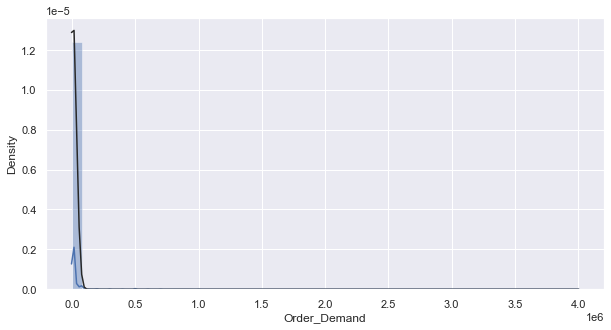

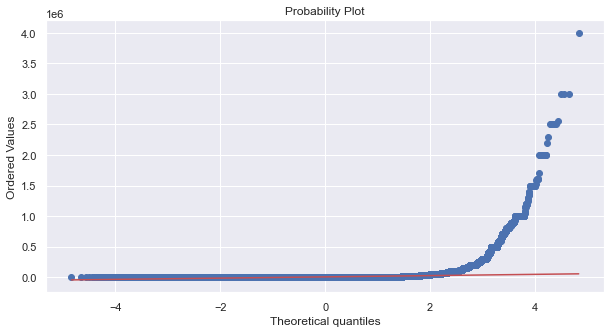

In [49]:
# let check the distribution of the target (Order Demand)
from matplotlib import rcParams
# figure size
rcParams['figure.figsize'] = 10,5

sns.distplot(data['Order_Demand'], fit=norm)
# 모집단이 정규성을 띈다면 직선형태로 나타나겠으나 아래 plot은 그렇지 않음 따라서 정규성을 띄지 않는다
fig = plt.figure()
prob = stats.probplot(data['Order_Demand'], plot=plt)
plt.show()

In [50]:
data['Order_Demand'].skew() # --> ARIMA를 적용할땐 왜도 skew가 높아도 상관 없는지????

#The data is highly skewed, but since we'll be applying ARIMA, it's fine.
# data의 왜도(skewness) : 분포의 비대칭도 : 왼쪽으로 치우침 : 왜도 > 0, 오른쪽으로 치우침 : 왜도 < 0 
# 왜도가 0 이면 정규분포를 따른다, 예측변수와 목표변수가 정규분포를 따를 때, 더 신뢰있는 예측이 이루어진다

31.432925049321977

In [52]:
data['Order_Demand'].describe()

count   1037336.00000
mean       4949.38374
std       29073.43975
min           0.00000
25%          20.00000
50%         300.00000
75%        2000.00000
max     4000000.00000
Name: Order_Demand, dtype: float64

In [84]:
log_data = np.log1p(data['Order_Demand'])

In [85]:
log_data.describe()

count   1037336.00000
mean          5.39096
std           2.93923
min           0.00000
25%           3.04452
50%           5.70711
75%           7.60140
max          15.20181
Name: Order_Demand, dtype: float64

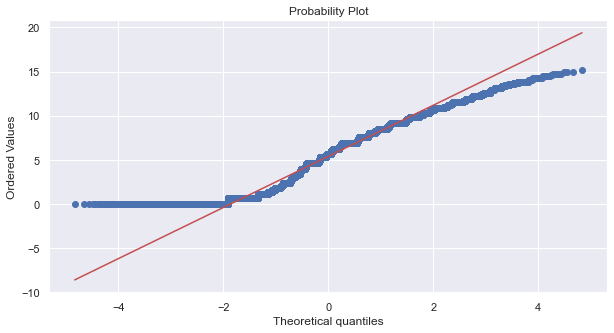

In [86]:
fig = plt.figure()
prob = stats.probplot(log_data, plot=plt)
plt.show()

skew(왜도) 왜도 처리 방법
- 로그변환을 해줘서 정규분포에 근사시킨다. 
1. 최소값을 확인. data['Order_Demand'].describe() 최솟값이 0보다 작다면 최소값+1 해준다
2. log_data = np.log(data['Order_Demand']) log변환을 시켜준다
3. log_data.skew() 왜도를 확인해서 정규분포에 근사한지 확인해준다
4. sns.distplot(log_data) 플롯을 그려 확인해준다

https://dining-developer.tistory.com/18

In [87]:
# target var EDA
pd.options.display.float_format = '{:.5f}'.format #지수 표기법 e로 안나타내기
data['Order_Demand'].describe()

count   1037336.00000
mean       4949.38374
std       29073.43975
min           0.00000
25%          20.00000
50%         300.00000
75%        2000.00000
max     4000000.00000
Name: Order_Demand, dtype: float64

## Univariate Analysis - Warehouse, Product Category.

In [88]:
# warehouse shipping by orders
data['Warehouse'].unique()

array(['Whse_J', 'Whse_S', 'Whse_C', 'Whse_A'], dtype=object)

In [89]:
# how many warehouse each?
data['Warehouse'].value_counts().sort_values(ascending = False)
#data.groupby('Warehouse')['Order_Demand'].count()
#data.groupby('Warehouse').count()['Order_Demand']

Whse_J    764447
Whse_A    142335
Whse_S     88200
Whse_C     42354
Name: Warehouse, dtype: int64

In [90]:
# The amount of orders shipped by each warehouse
data.groupby('Warehouse').sum().sort_values(by = 'Order_Demand', ascending = False)
#Warehouse J is clearly shipping most orders. However S is shipping more quantity within fewer requested orders.

,Order_Demand
Warehouse,
Whse_J,3363200396.00000
Whse_S,1038024700.00000
Whse_C,585071404.00000
Whse_A,147877431.00000


In [91]:
# count products
len(data['Product_Category'].value_counts())


33

Text(0.5, 1.0, 'Product_Category')

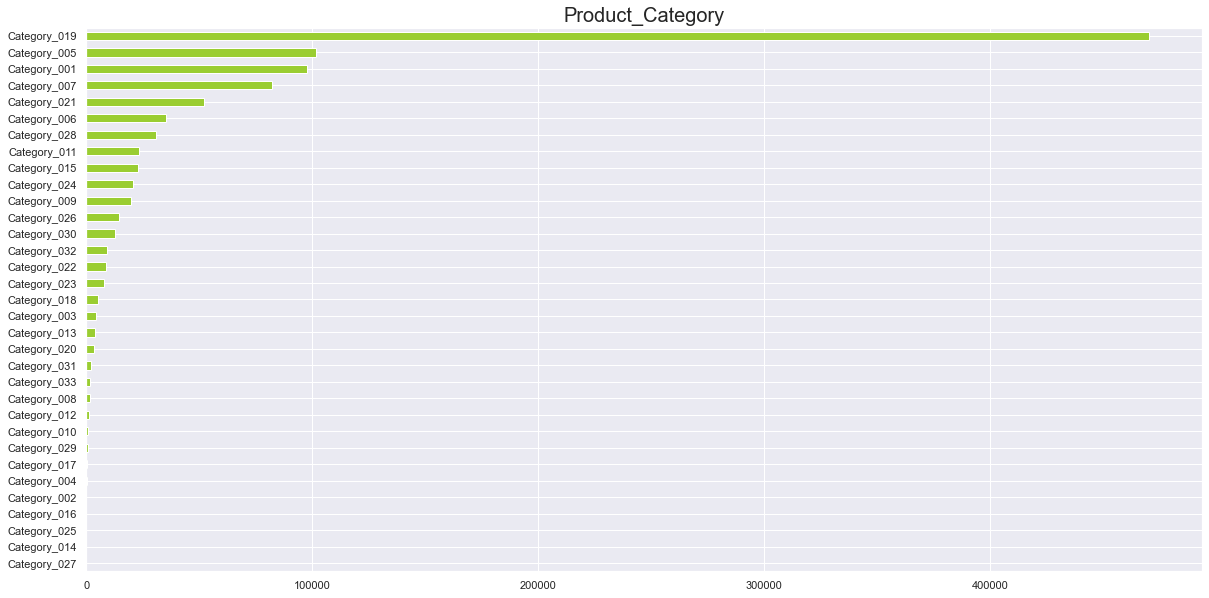

In [92]:
data['Product_Category'].value_counts().sort_values().plot.barh(figsize = (20,10),
                                                                color = 'yellowgreen').set_title('Product_Category', size =20)

In [18]:
# 보완할 것
#product_data = pd.DataFrame(data = data['Product_Category'].value_counts()).reset_index()
#product_data.columns = ['category', 'count']
#product_data

In [19]:
# 보완할 것
#plt.figure(figsize = (15,10))
#sns.countplot(data = product_data)

# Bivariate Analysis - Warehouse, Product Category with target variable.

In [93]:
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


Text(0.5, 1.0, 'Warehouse & Order_demand')

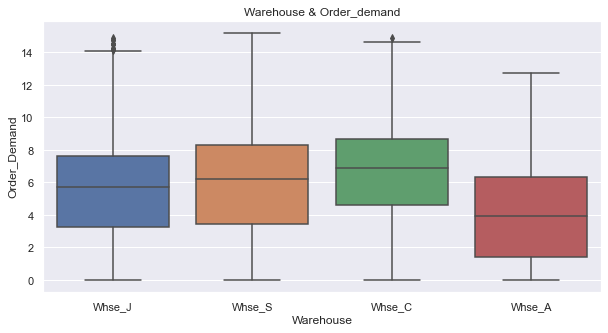

In [94]:
# Let's check the orders by warehouse -- > boxplot
sns.boxplot(x=data['Warehouse'], y = np.log1p(data['Order_Demand'])).set_title('Warehouse & Order_demand')

Text(0.5, 1.0, 'Product_Category & Demand')

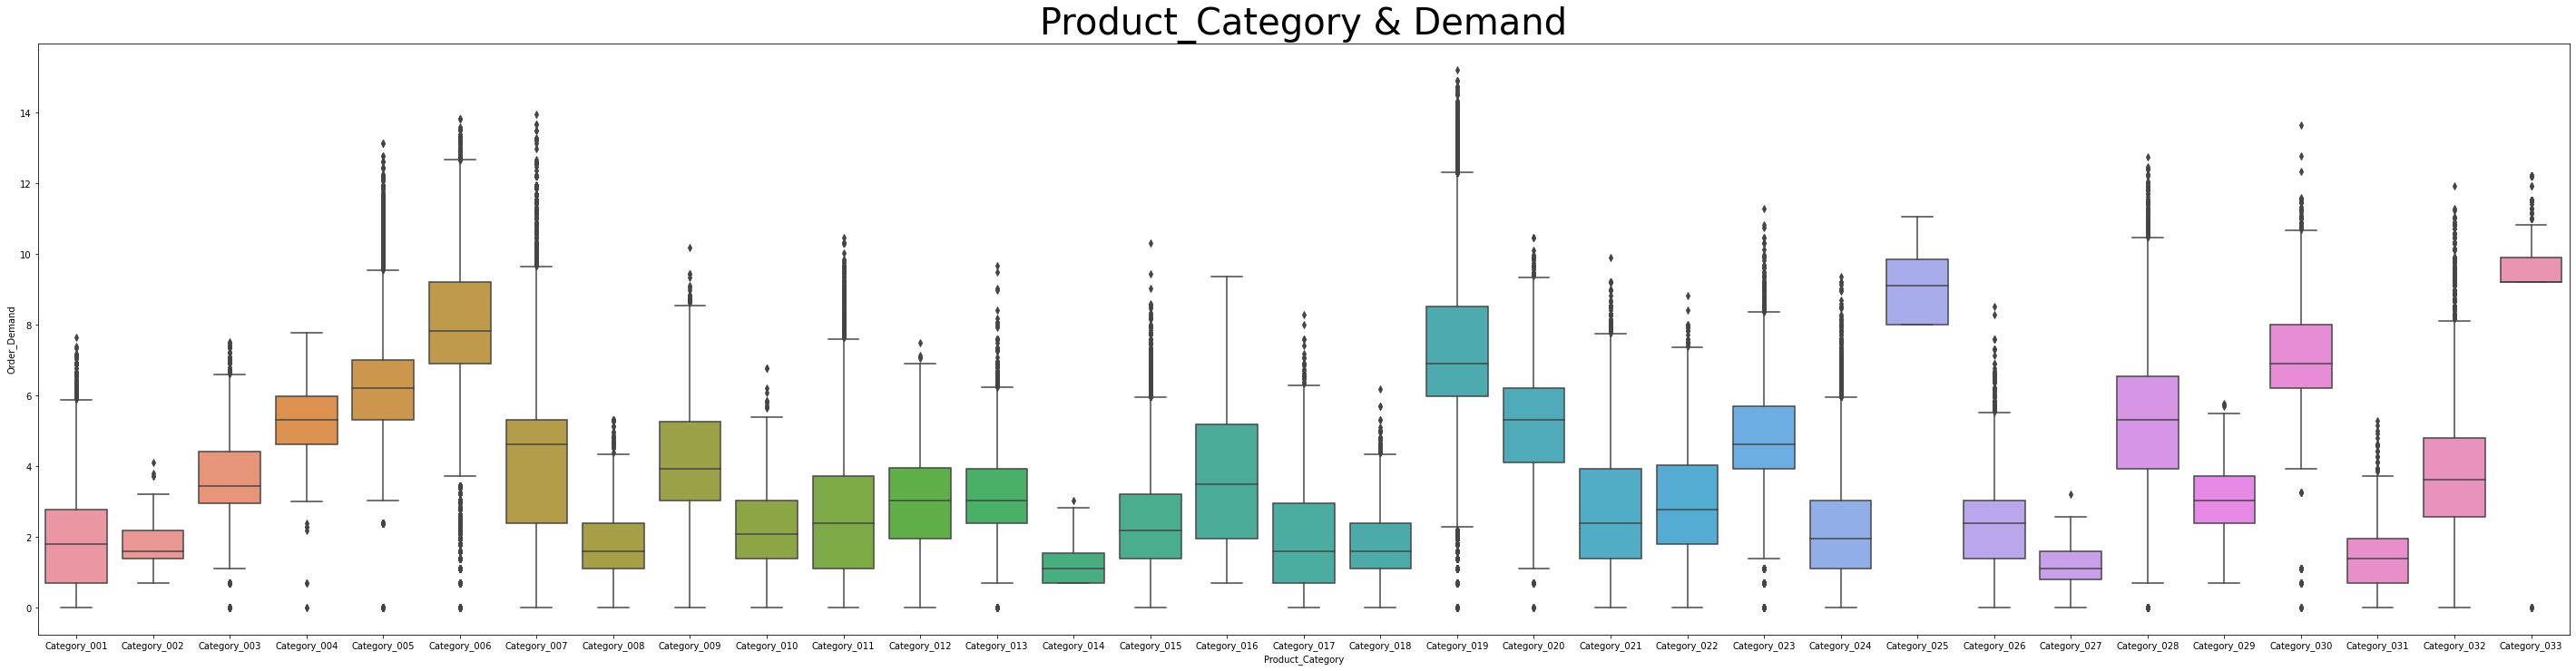

In [22]:
sample_data = data.sample(n=22222).reset_index()
plt.figure(figsize = (50,12))
sns.boxplot(x=data['Product_Category'].sort_values(), y = np.log1p(data['Order_Demand'])).set_title('Product_Category & Demand', size = 40)

# EDA as TIME SERIES

In [95]:
data.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500


In [96]:
demand_data = data.groupby('Date')['Order_Demand'].sum().reset_index()
demand_data

,Date,Order_Demand
0,2011-01-08,2
1,2011-05-31,108
2,2011-06-24,92000
3,2011-09-02,1250
4,2011-09-27,28
...,...,...
1724,2017-01-03,2400
1725,2017-01-04,29250
1726,2017-01-05,83929
1727,2017-01-06,175140


In [97]:
demand_data = demand_data.set_index('Date')
demand_data

,Order_Demand
Date,
2011-01-08,2
2011-05-31,108
2011-06-24,92000
2011-09-02,1250
2011-09-27,28
...,...
2017-01-03,2400
2017-01-04,29250
2017-01-05,83929


In [114]:
# Average daily sales value for a month, & we are using the start of each month as the timestamp
# *** demand_data['Order_Demand'].resample('MS').mean() -- > 시계열의 월초 기준으로 데이터 평균 리샘플링
# *** demand_data['Order_Demand'].resample('M').mean() -- > 시계열의 월말 기준으로 데이터 평균 리샘플링
# *** demand_data['Order_Demand'].resample('W').mean() -- > 시계열의 1주 기준으로 데이터 평균 리샘플링
# beginning_demand --> 기초수요
month_demand_df = demand_data['Order_Demand'].resample('MS').mean()
week_demand_df = demand_data['Order_Demand'].resample('W').mean()
print(month_demand_df)
print(week_demand_df)

Date
2011-01-01         2.00000
2011-02-01             NaN
2011-03-01             NaN
2011-04-01             NaN
2011-05-01       108.00000
                  ...     
2016-09-01   2774960.57143
2016-10-01   3000027.03571
2016-11-01   3218877.42857
2016-12-01   3096074.30769
2017-01-01     49161.16667
Freq: MS, Name: Order_Demand, Length: 73, dtype: float64
Date
2011-01-09         2.00000
2011-01-16             NaN
2011-01-23             NaN
2011-01-30             NaN
2011-02-06             NaN
                  ...     
2016-12-18   3319841.50000
2016-12-25   2913258.33333
2017-01-01   1855267.00000
2017-01-08     58157.80000
2017-01-15      4178.00000
Freq: W-SUN, Name: Order_Demand, Length: 315, dtype: float64


In [115]:
# there are NULL VALUES, i gotta imputed using bfill
month_demand_df = month_demand_df.fillna(month_demand_df.ffill())
week_demand_df = week_demand_df.fillna(week_demand_df.ffill())

Text(0, 0.5, 'Demand')

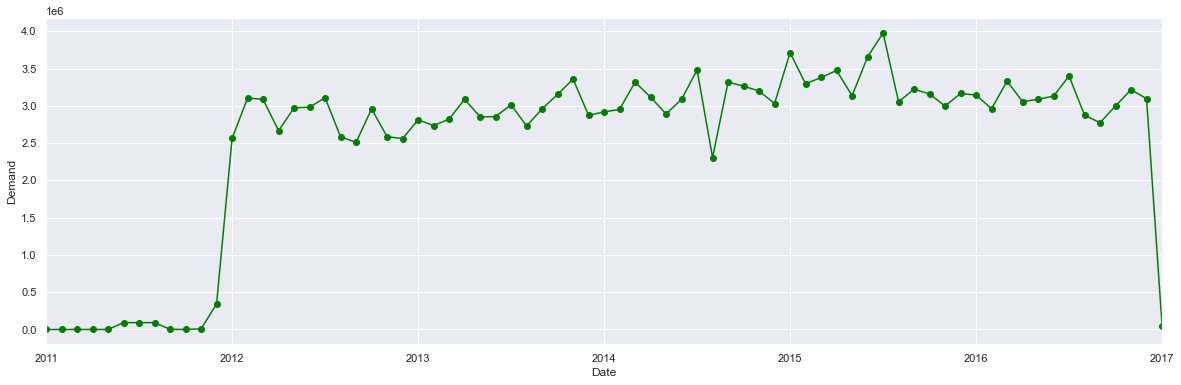

In [118]:
# Visualizing TIME SERIES
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn; seaborn.set()

plt.figure(figsize = (20,6))
month_demand_df.plot(style = ('-o'), color = 'green')
plt.ylabel('Demand for month')

# core point : The sales are always low for the beginning of the year and after the highest peak in demand
# The observed trend shows that orders were higher during 2014 - 2016 and then reducing

Text(0, 0.5, 'demand for week')

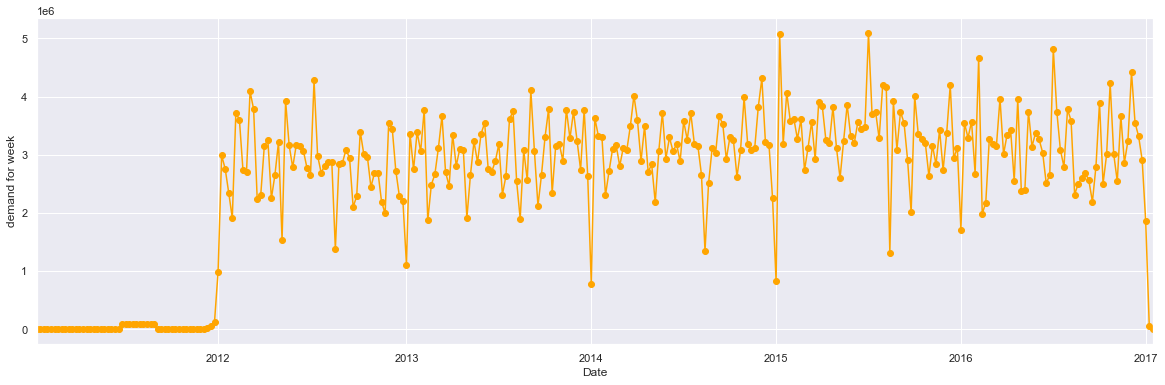

In [121]:
plt.figure(figsize = (20,6))
week_demand_df.plot(style = ('-o'), color = 'orange')
plt.ylabel('demand for week')

#### the time series Decomposition(시계열 분해) is a great way to check the seasonality, trends and residuals.

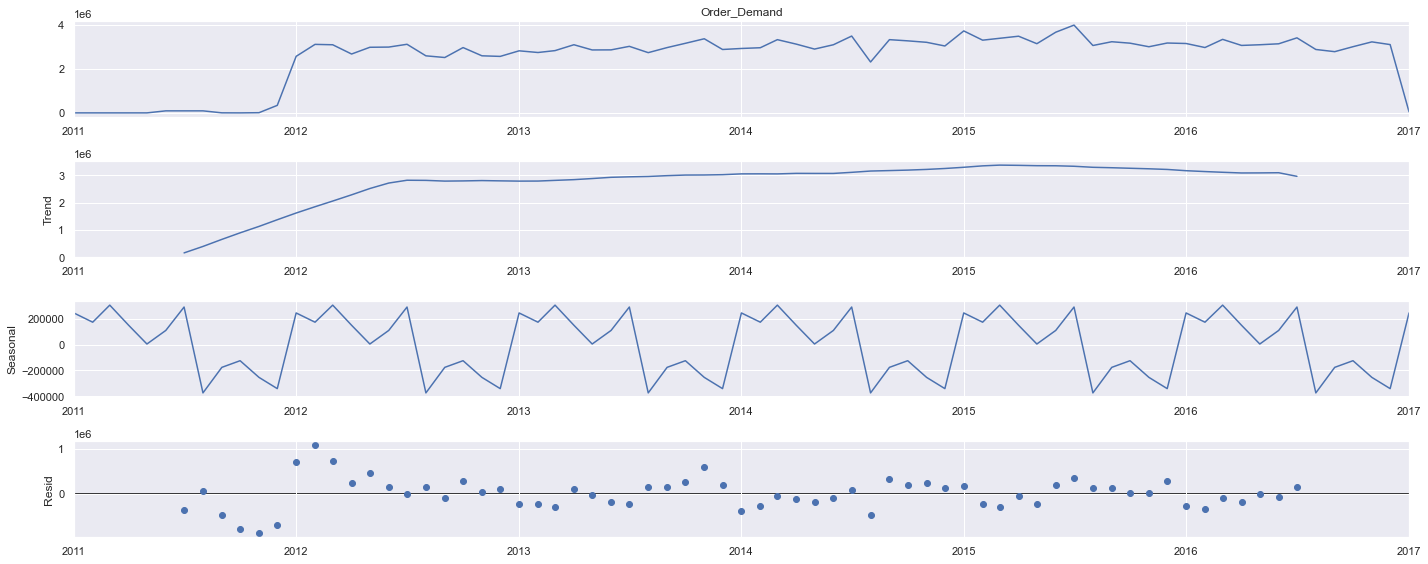

In [125]:
# Time series decomposition
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(month_demand_df , model = 'additive')
fig = decomposition.plot()

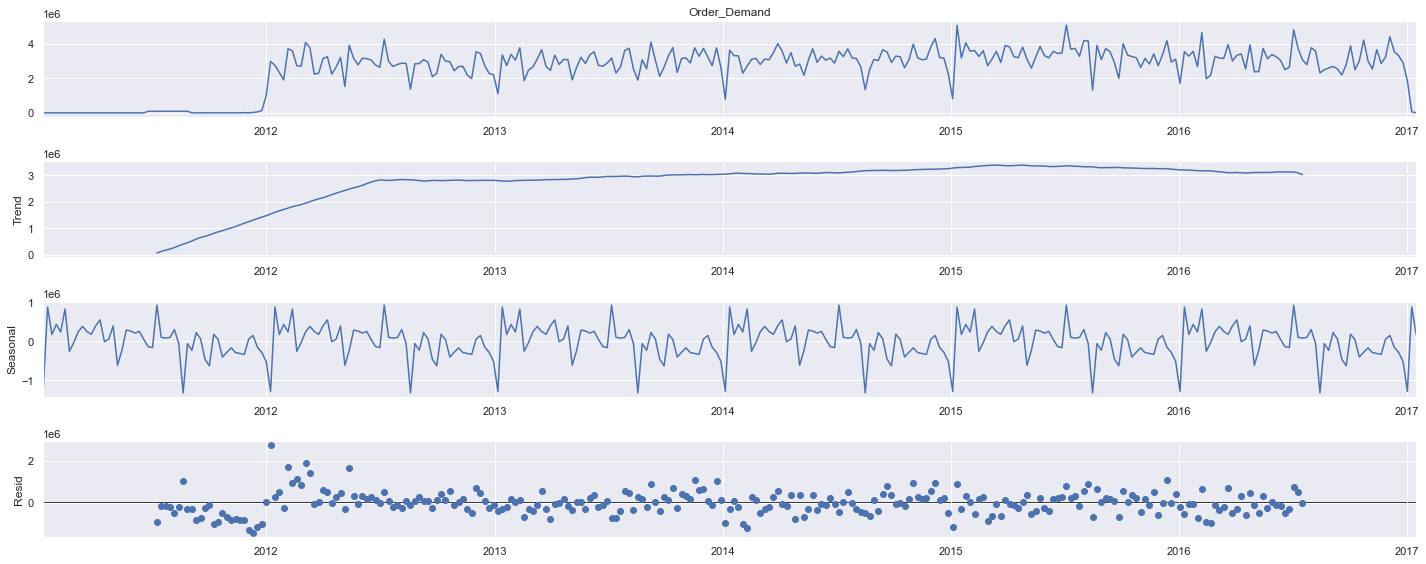

In [127]:
rcParams['figure.figsize'] = 20, 8
decomposition = sm.tsa.seasonal_decompose(week_demand_df , model = 'additive')
fig = decomposition.plot()

## ARIMA 모델 정리
An ARIMA analyze is characterized by 3 model : s, t, n, where these three parameters account for seasonality : s, trend : t, noise in data : n

- s is the order of the auto regressive integrated, if it snowed for the last week, then it will snow tomorrow
- t is order of the moving average 
- n is number of differencing required to make the time series stationarym if already stationary n = 0


## 1. Grid search 란 무엇인가?
0) 컨셉  : 모델에게 가장 적합한 하이퍼 파라미터를 찾기 
Grid search (격자 탐색) 은 모델 하이퍼 파라미터에 넣을 수 있는 값들을

순차적으로 입력한뒤에 가장 높은 성능을 보이는 하이퍼 파라미터들을 찾는 탐색 방법이다. 

 

다시 모델을 학생에 비유해보자면, 학생에게 문제집을 공부시키기 위해선 여러가지 공부법이 있다.

이 공부법들은 머신러닝/딥러닝 수많은 학습 모델 종류들에 해당 된다. 

그리고 그 공부 방법에서도 세부적인 규율들이 있을 것이다.

 

하루에 몇쪽 풀고 모의고사 칠지, 몇번씩 보고 다음페이지 넘어갈지 어디까지 깊게 공부할지 등등

이 세부적인 규율이 하이퍼 파라미터라 생각을 한다. 그리고 그리드 서치는 그 세부적인 규율을 일일히 다 적용해봐가면서

어떤 규율이 가장 이 공부법(모델)에 적합한지 판단하는 것이다. 


https://huidea.tistory.com/32

https://catloaf.tistory.com/25

https://soundprovider.tistory.com/entry/python-itertools --> itertools.product

In [102]:
try:
    x = int(input('나눌 숫자를 입력하세요: '))
    y = 10 / x
    print(y)
except:    # 예외가 발생했을 때 실행됨
    print('예외가 발생했습니다.')

나눌 숫자를 입력하세요:  5


2.0


In [137]:
import itertools
t = s = n = range(0,2) #0,1,2 만 출력
tsn = list(itertools.product(t,s,n))
seasonal_tsn_month = [(x[0], x[1], x[2], 12) for x in list(itertools.product(t,s,n))]
seasonal_tsn_week = [(x[0], x[1], x[2], 4) for x in list(itertools.product(t,s,n))]

print('Examples of parameters combinations for seasonal ARIMA')
print('SARIMA : {} x {}'. format(tsn[1], seasonal_tsn[1]))
print('SARIMA : {} x {}'. format(tsn[1], seasonal_tsn[2]))
print('SARIMA : {} x {}'. format(tsn[2], seasonal_tsn[3]))
print('SARIMA : {} x {}'. format(tsn[2], seasonal_tsn[4]))

Examples of parameters combinations for seasonal ARIMA
SARIMA : (0, 0, 1) x (0, 0, 1, 12)
SARIMA : (0, 0, 1) x (0, 1, 0, 12)
SARIMA : (0, 1, 0) x (0, 1, 1, 12)
SARIMA : (0, 1, 0) x (1, 0, 0, 12)


In [138]:
for param in tsn:
    for param_seasonal_month in seasonal_tsn_month:
        try:
            mod = sm.tsa.statespace.SARIMAX(month_demand_df, 
                                          order = param,
                                          seasonal_order = param_seasonal_month,
                                          enforce_stationarity=False,
                                          enforce_invertibility = False)
            results = mod.fit()
            
            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal_month, results.aic)) # .format() 해서 변수 할당
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2344.0725874471186
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1934.082106081394
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1862.0101867036954
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1413.1954170987105
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1897.2735210354695
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1994.595603264162
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1440.5974740527085
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1414.083614885848
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2265.2699429307913
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1876.50501548817
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1790.1219024704828
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1411.8345179989296
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1934.7741794222513
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1872.8138323280539
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1471.396926540257
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1413.7383149943712
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2081.8490117343954
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC

In [139]:
for param in tsn:
    for param_seasonal_week in seasonal_tsn_week:
        try:
            mod = sm.tsa.statespace.SARIMAX(week_demand_df, 
                                          order = param,
                                          seasonal_order = param_seasonal_week,
                                          enforce_stationarity=False,
                                          enforce_invertibility = False)
            results = mod.fit()
            
            print('SARIMA{}x{}4 - AIC:{}'.format(param, param_seasonal_week, results.aic)) # .format() 해서 변수 할당
        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 0, 4)4 - AIC:10230.059722431779
SARIMA(0, 0, 0)x(0, 0, 1, 4)4 - AIC:9930.529138613274
SARIMA(0, 0, 0)x(0, 1, 0, 4)4 - AIC:9395.696610133162
SARIMA(0, 0, 0)x(0, 1, 1, 4)4 - AIC:9203.54875074996
SARIMA(0, 0, 0)x(1, 0, 0, 4)4 - AIC:9419.622008424743
SARIMA(0, 0, 0)x(1, 0, 1, 4)4 - AIC:9321.726902371716
SARIMA(0, 0, 0)x(1, 1, 0, 4)4 - AIC:9242.712196973185
SARIMA(0, 0, 0)x(1, 1, 1, 4)4 - AIC:9205.317268982815
SARIMA(0, 0, 1)x(0, 0, 0, 4)4 - AIC:10009.35816992856
SARIMA(0, 0, 1)x(0, 0, 1, 4)4 - AIC:9830.24422267079
SARIMA(0, 0, 1)x(0, 1, 0, 4)4 - AIC:9359.645719171216
SARIMA(0, 0, 1)x(0, 1, 1, 4)4 - AIC:9161.267258363527
SARIMA(0, 0, 1)x(1, 0, 0, 4)4 - AIC:9853.83477776105
SARIMA(0, 0, 1)x(1, 0, 1, 4)4 - AIC:9785.214419317264
SARIMA(0, 0, 1)x(1, 1, 0, 4)4 - AIC:9235.921984227403
SARIMA(0, 0, 1)x(1, 1, 1, 4)4 - AIC:9163.254277626718
SARIMA(0, 1, 0)x(0, 0, 0, 4)4 - AIC:9425.876944428543
SARIMA(0, 1, 0)x(0, 0, 1, 4)4 - AIC:9311.476820545495
SARIMA(0, 1, 0)x(0, 1, 0, 4)4 

In [135]:
# fit the model with the best params
# SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1337.2555688071777
# therefore we should consider this to be optimal option

from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = sm.tsa.statespace.SARIMAX(month_demand_df,
                               order = (1,1,1),
                               seasonal_order = (1,1,1,12),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results1 = model1.fit()
print(results1.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Order_Demand   No. Observations:                   73
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -663.628
Date:                            Sun, 27 Feb 2022   AIC                           1337.256
Time:                                    17:45:10   BIC                           1346.399
Sample:                                01-01-2011   HQIC                          1340.681
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2946      0.655      0.450      0.653      -0.988       1.578
ma.L1         -0.9862      0.018   

In [140]:
# SARIMA(1, 1, 1)x(1, 1, 1, 4)4 - AIC:9135.82129644496
model2 = sm.tsa.statespace.SARIMAX(week_demand_df,
                               order = (1,1,1),
                               seasonal_order = (1,1,1,4),
                               enforce_stationarity = False,
                               enforce_invertibility = False)
results2 = model2.fit()
print(results2.summary())

                                     SARIMAX Results                                     
Dep. Variable:                      Order_Demand   No. Observations:                  315
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood               -4562.911
Date:                           Sun, 27 Feb 2022   AIC                           9135.821
Time:                                   17:50:44   BIC                           9154.406
Sample:                               01-09-2011   HQIC                          9143.256
                                    - 01-15-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1217      0.181      0.672      0.502      -0.234       0.477
ma.L1         -0.7869      0.135     -5.825

Interpreting the table:

coeff: Shows weight/impotance how each feature impacts the time series.
Pvalue: Shows the significance of each feature weight. Can test hypothesis using this.
If p value is <.05 then they are statitically significant.

- ling_box: white noise 따름
- jarque_bera : 정규분포 따름
- heteroske : 분산이 일정함, 

So, if the p-value is < .05 then there is a relationship between the response and predictor. Hence, significant.

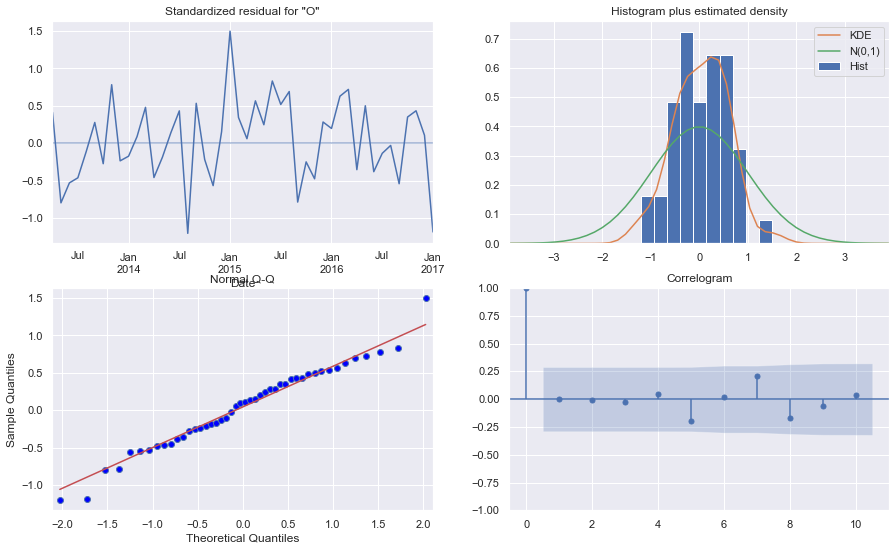

In [142]:
#Plotting the diagnostics.

#The plot_diagnostics object allows us to quickly generate model diagnostics and investigate for any unusual behavior.

results1.plot_diagnostics(figsize= (15,9))
plt.show()

#What to look for?
#1. Residuals SHOULD be Normally Distributed ; Check
#Top Right: The (orange colored) KDE line should be closely matched with green colored N(0,1) line. This is the standard notation
#for normal distribution with mean 0 and sd 1.
#Bottom Left: The qq plot shows the ordered distribution of residuals (blue dots) follows the linear trend of the samples 
#taken from a standard normal distribution with N(0, 1). 

#2. #Residuals are not correlated; Check
#Top Left: The standard residuals don’t display any obvious seasonality and appear to be white noise. 
#Bottom Right: The autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have 
#low correlation with its own lagged versions.

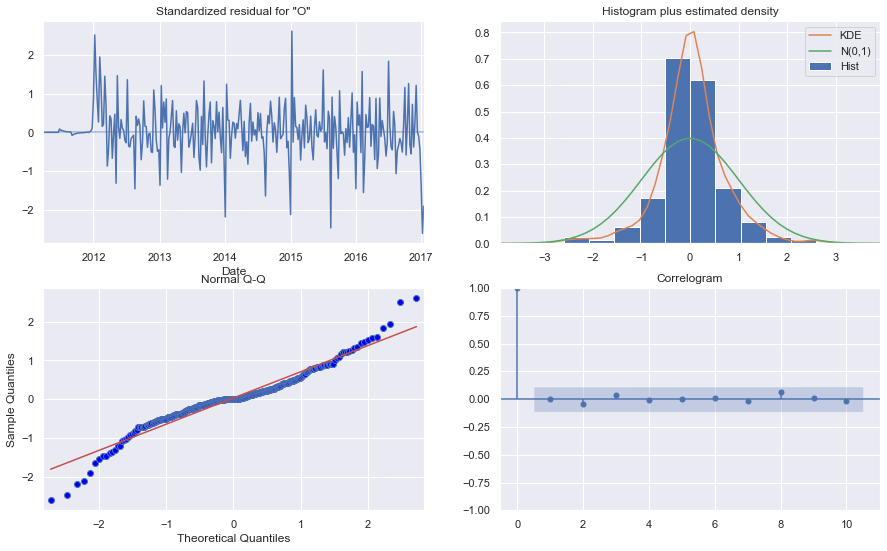

In [143]:
results2.plot_diagnostics(figsize= (15,9))
plt.show()

# Model Validation

In [108]:
print(beginning_demand.index.min())
print(beginning_demand.index.max())

2011-01-01 00:00:00
2017-01-01 00:00:00


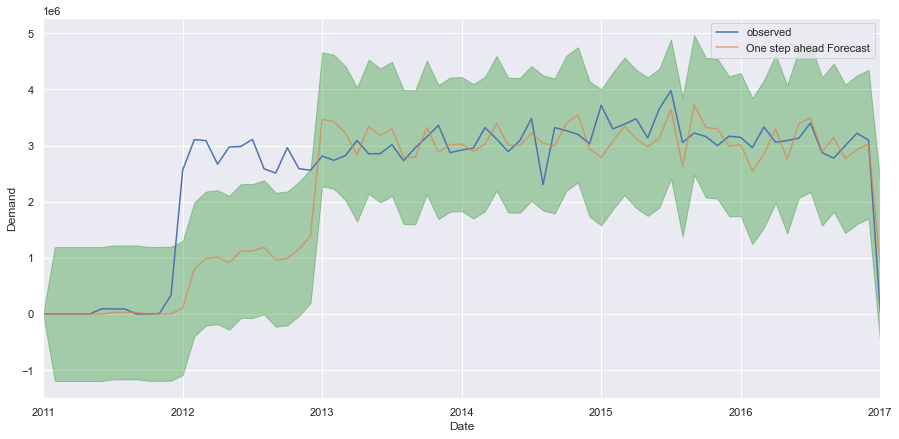

In [148]:
# Lets get the predcition
prediction = results1.get_prediction(start=pd.to_datetime('2011-01-01'), dynamic=False)#false is when using the entire history
# confidence inteval
prediction_ci = prediction.conf_int()

# plotting true demand & forecasted demand
ax = month_demand_df['2010':].plot(label='observed')
prediction.predicted_mean.plot(ax=ax, label = 'One step ahead Forecast', alpha=0.7, figsize=(15,7))
ax.fill_between(prediction_ci.index,
               prediction_ci.iloc[:,0],
               prediction_ci.iloc[:, 1], color = 'green', alpha = 0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()
plt.show()

In [156]:
week_demand_df

Date
2011-01-09         2.00000
2011-01-16         2.00000
2011-01-23         2.00000
2011-01-30         2.00000
2011-02-06         2.00000
                  ...     
2016-12-18   3319841.50000
2016-12-25   2913258.33333
2017-01-01   1855267.00000
2017-01-08     58157.80000
2017-01-15      4178.00000
Freq: W-SUN, Name: Order_Demand, Length: 315, dtype: float64

In [157]:
month_demand_df

Date
2011-01-01         2.00000
2011-02-01         2.00000
2011-03-01         2.00000
2011-04-01         2.00000
2011-05-01       108.00000
                  ...     
2016-09-01   2774960.57143
2016-10-01   3000027.03571
2016-11-01   3218877.42857
2016-12-01   3096074.30769
2017-01-01     49161.16667
Freq: MS, Name: Order_Demand, Length: 73, dtype: float64

C:\Users\82102\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


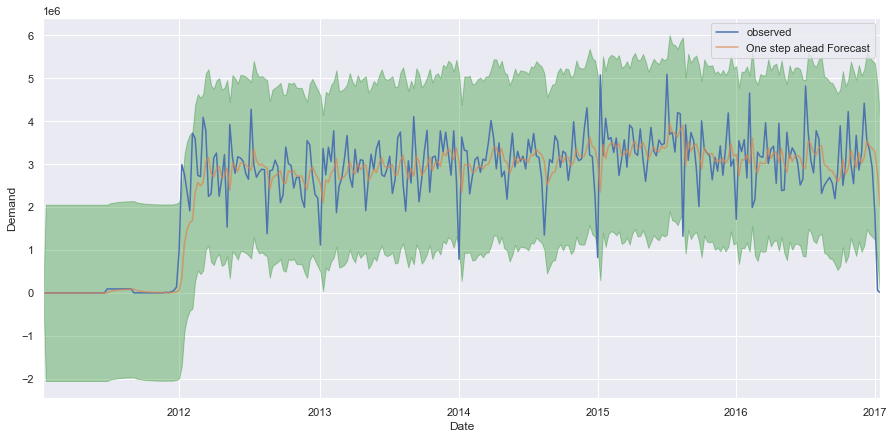

In [153]:
# Lets get the predcition
prediction2 = results2.get_prediction(start=pd.to_datetime('2011-01-09'), dynamic=False)#false is when using the entire history
# confidence inteval
prediction_ci2 = prediction2.conf_int()

# plotting true demand & forecasted demand
ax = week_demand_df['2010':].plot(label='observed')
prediction2.predicted_mean.plot(ax=ax, label = 'One step ahead Forecast', alpha=0.7, figsize=(15,7))
ax.fill_between(prediction_ci2.index,
               prediction_ci2.iloc[:,0],
               prediction_ci2.iloc[:, 1], color = 'green', alpha = 0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.legend()
plt.show()

### Forecast Accuracy

In [160]:
# Get the mean squared error 
forcasted = prediction.predicted_mean
truth = month_demand_df['2016-09-01':]
mse = ((forcasted - truth) ** 2).mean()
print('MSE : {}'.format(round(mse, 2)))

#smaller is better

MSE : 206907817470.38


In [161]:
print('RMSE : {}'.format(round(np.sqrt(mse), 2)))

RMSE : 454871.21


In [166]:
forcasted2 = prediction2.predicted_mean
truth2 = week_demand_df['2016-12-18':]
mse = ((forcasted2 - truth2) ** 2).mean()
print('MSE : {}'.format(round(mse, 2)))

MSE : 2735198373595.79


In [167]:
print('RMSE : {}'.format(round(np.sqrt(mse), 2)))

RMSE : 1653843.52
